In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

import acquire, summarize, wrangle_zillow, model

In [3]:
# Acquire the zillow dataset

zillow = acquire.get_zillow_clustering()
zillow.shape

(77579, 69)

In [4]:
# Wrangle the zillow dataset

train, validate, test = wrangle_zillow.wrangle_zillow_clustering(zillow)

# Double check the shape of the splitted datasets
train.shape, validate.shape, test.shape

((31028, 30), (13299, 30), (7823, 30))

In [5]:
# Check if null values still exist

train.isna().sum().sum(), validate.isna().sum().sum(), test.isna().sum().sum()

(0, 0, 0)

In [6]:
# Map fips number to county names

def add_county_column(row):
    if row['fips'] == 6037:
        return 'Los Angeles'
    elif row['fips'] == 6059:
        return 'Orange'
    elif row['fips'] == 6111:
        return 'Ventura'
    
train.fips = train.apply(lambda i: add_county_column(i), axis=1)
train.shape

(31028, 30)

In [7]:
# Summarize train datasets

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31028 entries, 29866 to 36325
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         31028 non-null  float64
 1   parcelid                      31028 non-null  int64  
 2   bathroomcnt                   31028 non-null  float64
 3   bedroomcnt                    31028 non-null  float64
 4   buildingqualitytypeid         31028 non-null  float64
 5   calculatedfinishedsquarefeet  31028 non-null  float64
 6   finishedsquarefeet12          31028 non-null  float64
 7   fips                          31028 non-null  object 
 8   fullbathcnt                   31028 non-null  float64
 9   latitude                      31028 non-null  float64
 10  longitude                     31028 non-null  float64
 11  lotsizesquarefeet             31028 non-null  float64
 12  propertycountylandusecode     31028 non-null  object 
 1

## Explore the target variable - logerror

In [8]:
# Create a dataframe to hold the target variable

target_var = train.logerror
target_var.shape

(31028,)

In [9]:
# Compute the descriptive statistics of the logerror

train.logerror.describe()

count    31028.000000
mean         0.019994
std          0.177948
min         -4.655420
25%         -0.024426
50%          0.007173
75%          0.040787
max          3.394544
Name: logerror, dtype: float64

[Text(0.5, 0, '')]

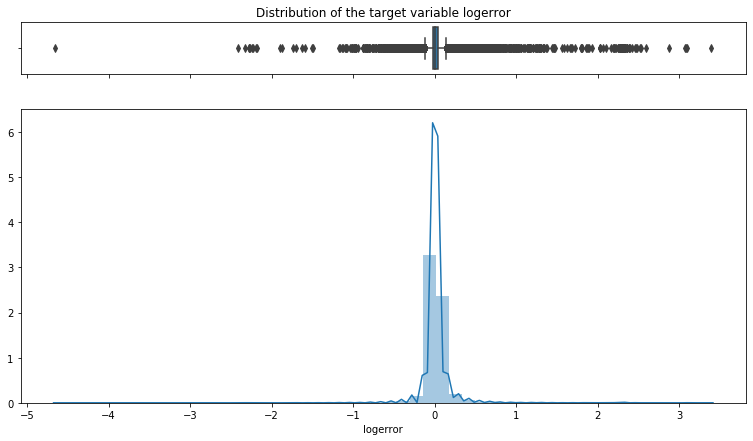

In [10]:
# Visualize the logerror distribution by boxplot and histogram

# Cut the window into 2 parts
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(13,7),  
                                      gridspec_kw={"height_ratios": (0.15, 0.85)})

# Add a graph in each part
sns.boxplot(target_var, ax=ax_box)
sns.distplot(target_var, kde=True, ax=ax_hist)


# Add title
ax_box.set_title('Distribution of the target variable logerror')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [11]:
# Print the descriptive statistics of the control cell viability dataset

percentiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9]

target_var.describe(percentiles).round(3)

count    31028.000
mean         0.020
std          0.178
min         -4.655
10%         -0.071
20%         -0.035
30%         -0.016
40%         -0.004
50%          0.007
60%          0.018
70%          0.031
80%          0.053
85%          0.071
90%          0.105
max          3.395
Name: logerror, dtype: float64

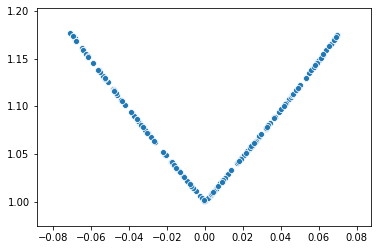

In [12]:
X = np.random.uniform(low=-0.071, high=0.071, size=200)
Y = []

for x in X:
    if x > 0:
        y = 10**x
        Y.append(y)
    elif x < 0:
        y = 1/(10**x)
        Y.append(y)

sns.scatterplot(X, Y)

In [13]:
mask_low = train.logerror < -0.071
mask_medium = (train.logerror >= -0.071) & (train.logerror <=0.071)
mask_high = train.logerror > 0.071

In [14]:
train_low = train[mask_low]
train_medium = train[mask_medium]
train_high = train[mask_high]

train_low.shape, train_medium.shape, train_high.shape

((3073, 30), (23330, 30), (4625, 30))

In [15]:
train.fips.value_counts(normalize=True)

Los Angeles    0.649575
Orange         0.266727
Ventura        0.083699
Name: fips, dtype: float64

In [16]:
train_low.fips.value_counts(normalize=True)

Los Angeles    0.770908
Orange         0.172144
Ventura        0.056948
Name: fips, dtype: float64

In [17]:
train_medium.fips.value_counts(normalize=True)

Los Angeles    0.625332
Orange         0.283926
Ventura        0.090742
Name: fips, dtype: float64

In [18]:
train_high.fips.value_counts(normalize=True)

Los Angeles    0.691243
Orange         0.242811
Ventura        0.065946
Name: fips, dtype: float64

In [19]:
train.propertylandusetypeid.value_counts()

261.0    31026
260.0        2
Name: propertylandusetypeid, dtype: int64

In [20]:
# Divide the dataframe into two subgroups: + error and - error

# Any error eqauls 0? No
(train.logerror == 0).sum()

# Creat 2 masks for + and -

mask_positive = (train.logerror > 0)
mask_negative = (train.logerror < 0)

# Create two dfs for + and -

target_var_positive = train[mask_positive]
target_var_negative = train[mask_negative]

# Print the shapes of the two dfs
target_var_positive.shape, target_var_negative.shape

((17684, 30), (13344, 30))

In [21]:
target_var_positive.sample(5)

,propertylandusetypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
29491,261.0,12056481,2.0,2.0,8.0,1555.0,1555.0,Los Angeles,2.0,34163897.0,...,144256.0,333981.0,2016.0,189725.0,3733.85,6.037301e+13,0.027808,2017-04-18,Central,Single Family Residential
47130,261.0,12933257,3.0,3.0,6.0,1781.0,1781.0,Los Angeles,3.0,34076427.0,...,106100.0,533200.0,2016.0,427100.0,6595.34,6.037404e+13,0.001297,2017-06-08,Central,Single Family Residential
60576,261.0,14338618,2.5,2.0,6.0,2141.0,2141.0,Orange,2.0,33786639.0,...,212971.0,673759.0,2016.0,460788.0,7905.68,6.059076e+13,0.014502,2017-06-16,None,Single Family Residential
38313,261.0,12518571,2.0,3.0,6.0,1467.0,1467.0,Los Angeles,2.0,33807497.0,...,101424.0,318485.0,2016.0,217061.0,3875.83,6.037574e+13,0.035636,2017-05-30,Floor/Wall,Single Family Residential
58591,261.0,14235818,1.0,2.0,6.0,1220.0,1220.0,Orange,1.0,33788527.0,...,36446.0,488078.0,2016.0,451632.0,5389.94,6.059076e+13,0.326403,2017-04-07,None,Single Family Residential


In [22]:
target_var_negative.sample(5)

,propertylandusetypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
32053,261.0,12174402,2.0,2.0,6.0,1750.0,1750.0,Los Angeles,2.0,34176823.0,...,43465.0,80924.0,2016.0,37459.0,1289.83,6.037461e+13,-0.154061,2017-08-31,Central,Single Family Residential
52301,261.0,13925230,3.0,4.0,6.0,2524.0,2524.0,Orange,3.0,33793434.0,...,232621.0,558402.0,2016.0,325781.0,6593.22,6.059110e+13,-0.047626,2017-06-28,None,Single Family Residential
37724,261.0,12492433,1.0,3.0,4.0,1066.0,1066.0,Los Angeles,1.0,33834426.0,...,77921.0,389610.0,2016.0,311689.0,4924.13,6.037571e+13,-0.001514,2017-04-05,Floor/Wall,Single Family Residential
58027,261.0,14211486,3.5,4.0,6.0,3119.0,3119.0,Orange,3.0,33841623.0,...,503212.0,769000.0,2016.0,265788.0,8293.24,6.059076e+13,-0.002071,2017-04-28,None,Single Family Residential
13450,261.0,11234319,2.0,4.0,8.0,1742.0,1742.0,Los Angeles,2.0,34554137.0,...,124723.0,166227.0,2016.0,41504.0,2921.53,6.037911e+13,-0.012739,2017-04-25,Central,Single Family Residential


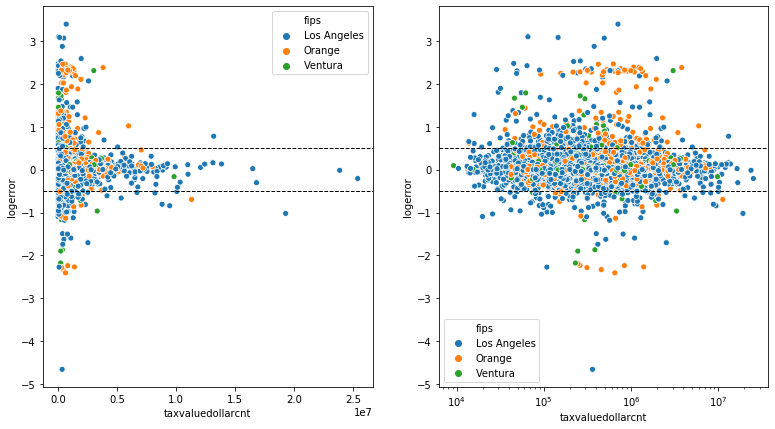

In [26]:
plt.figure(figsize=(13,7))

plt.subplot(121)
sns.scatterplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)

plt.subplot(122)
ax = sns.scatterplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='fips')
ax.set(xscale='log')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)

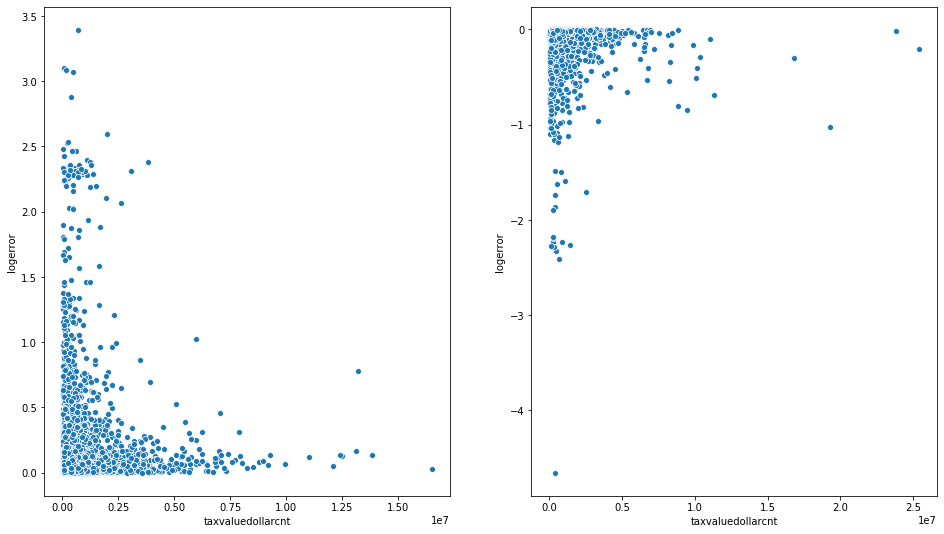

In [51]:
# Visualization of + erorr and - error distribution

plt.subplot(121)
sns.scatterplot(data=target_var_positive, x='taxvaluedollarcnt', y='logerror')

plt.subplot(122)
sns.scatterplot(data=target_var_negative, x='taxvaluedollarcnt', y='logerror')

In [53]:
# Add a new columns indicates positive or negative error

train['error_type'] = (train.logerror > 0)
train.shape

(31028, 31)

In [57]:
# Map the booleans values to 'positive' or 'negative'

train.error_type = train.error_type.map({True: 'positive', False: 'negative'})
train.shape

(31028, 31)

In [58]:
train.head()

,propertylandusetypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,error_type
29866,261.0,12074309,2.0,2.0,8.0,1432.0,1432.0,Los Angeles,2.0,34179406.0,...,344570.0,2016.0,275665.0,3860.72,6.037301e+13,-0.006079,2017-08-18,Central,Single Family Residential,negative
41663,261.0,12669907,2.0,3.0,6.0,1854.0,1854.0,Los Angeles,2.0,33807692.0,...,1877197.0,2016.0,1125912.0,21149.80,6.037651e+13,-0.017067,2017-08-04,Central,Single Family Residential,negative
15079,261.0,11302417,3.0,3.0,7.0,2542.0,2542.0,Los Angeles,3.0,34678747.0,...,195053.0,2016.0,36983.0,3259.47,6.037901e+13,-0.002666,2017-07-07,Central,Single Family Residential,negative
16280,261.0,11390652,2.0,4.0,6.0,1060.0,1060.0,Los Angeles,2.0,33985638.0,...,338074.0,2016.0,270460.0,4230.63,6.037235e+13,-0.056795,2017-03-24,Floor/Wall,Single Family Residential,negative
45895,261.0,12873988,2.0,3.0,6.0,1274.0,1274.0,Los Angeles,2.0,34071220.0,...,197982.0,2016.0,109929.0,2534.61,6.037403e+13,0.012496,2017-04-25,Central,Single Family Residential,positive


## Explore the All the features

In [6]:
# View all the columns of the training dataset. 

train.columns

Index(['propertylandusetypeid', 'parcelid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'heatingorsystemdesc', 'propertylandusedesc'],
      dtype='object')

### Group 1 House Setting
- bathroomcnt and fullbathcnt
- bedroomcnt
- roomcnt
- calculatedfinishedsquarefeet, finishedsquarefeet12
- lotsizesquarefeet

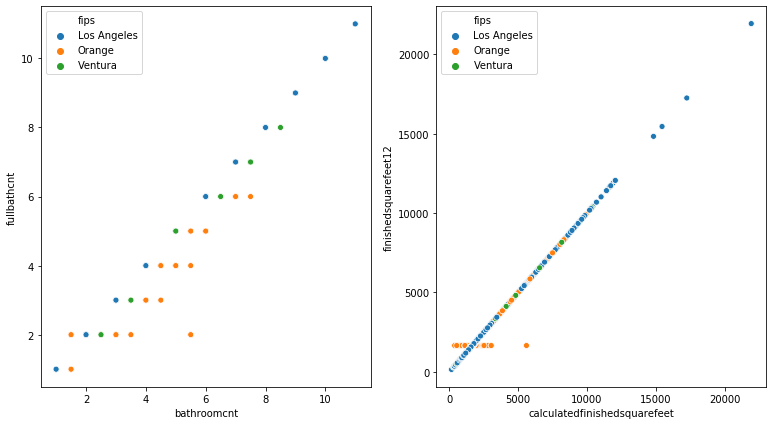

In [117]:
plt.figure(figsize=(13,7))

plt.subplot(121)
sns.scatterplot(data=train, x='bathroomcnt', y='fullbathcnt', hue='fips')

plt.subplot(122)
sns.scatterplot(data=train, x='calculatedfinishedsquarefeet', y='finishedsquarefeet12', hue='fips')

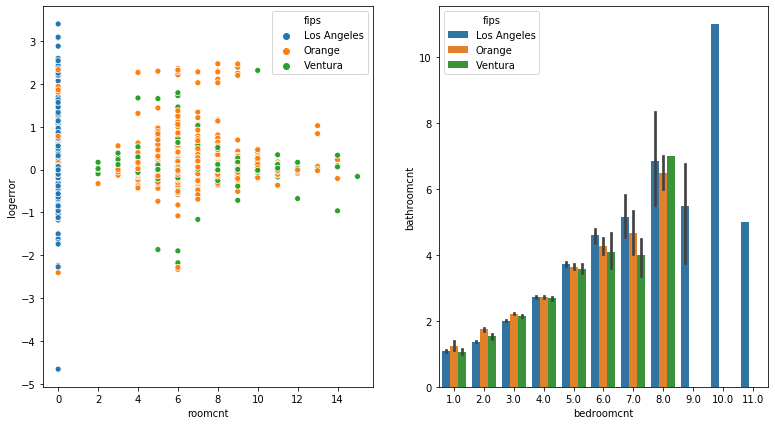

In [115]:
plt.figure(figsize=(13,7))

plt.subplot(121)
sns.scatterplot(data=train, x='roomcnt', y='logerror', hue='fips')

plt.subplot(122)
sns.barplot(data=train, x='bedroomcnt', y='bathroomcnt', hue='fips')

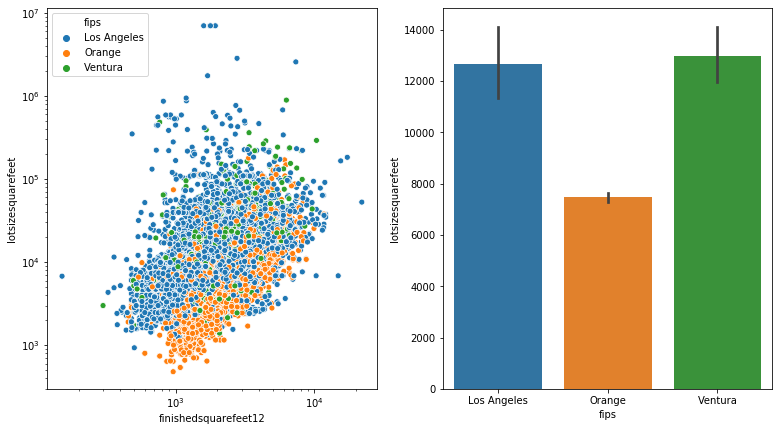

In [129]:
plt.figure(figsize=(13,7))

plt.subplot(121)
ax1 = sns.scatterplot(data=train, x='finishedsquarefeet12', y='lotsizesquarefeet', hue='fips')
ax1.set(xscale='log')
ax1.set(yscale='log')

plt.subplot(122)
ax2 = sns.barplot(data=train, x='fips', y='lotsizesquarefeet')

### Group 2: Property Conditions
- buildingqualitytypeid
- yearbuild
- heatingorsystemdesc

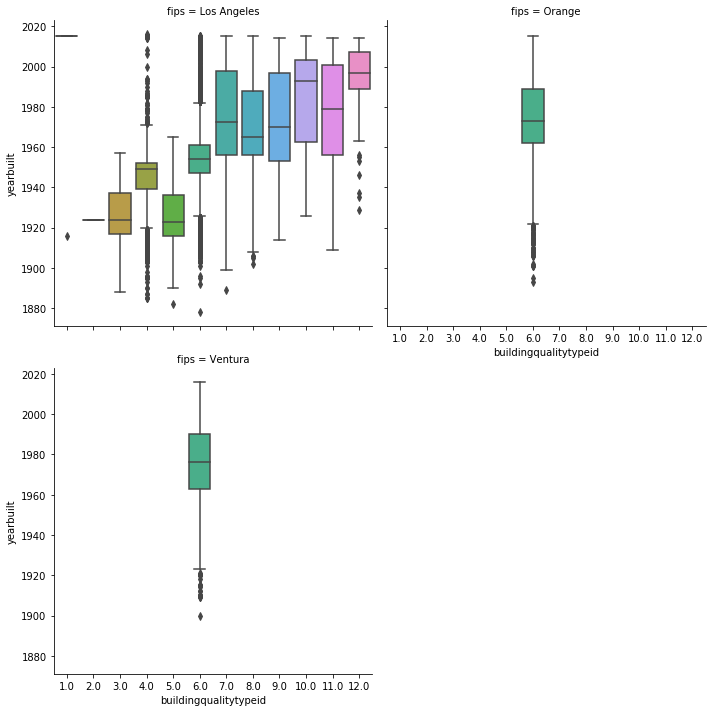

In [144]:

sns.catplot(data=train, x='buildingqualitytypeid', y='yearbuilt', col='fips', col_wrap=2, kind='box')

[Text(0.5, 0, '')]

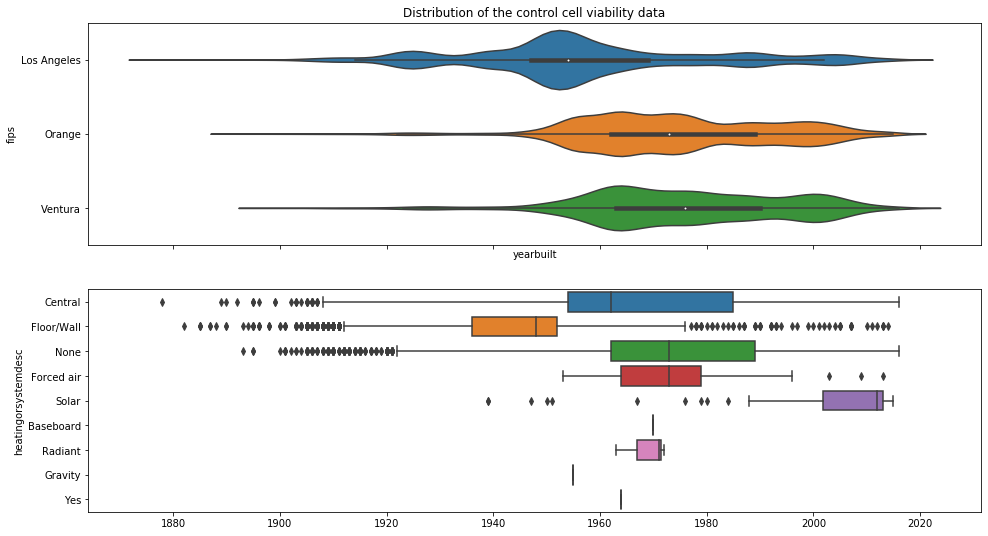

In [155]:
# Cut the window into 2 parts
fig, (ax_violin, ax_box) = plt.subplots(2, sharex=True, figsize=(16,9),  
                                            gridspec_kw={"height_ratios": (0.5, 0.5)})

# Add a graph in each part
sns.violinplot(data=train, x='yearbuilt', y='fips', ax=ax_violin)
sns.boxplot(data=train, x='yearbuilt', y='heatingorsystemdesc', ax=ax_box)

# Add title
ax_violin.set_title('Distribution of the control cell viability data')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

### Group 3: Values
- structuretaxvaluedollarcnt
- taxvaluedollarcnt
- landtaxvaluedollarcnt
- taxamount

[None]

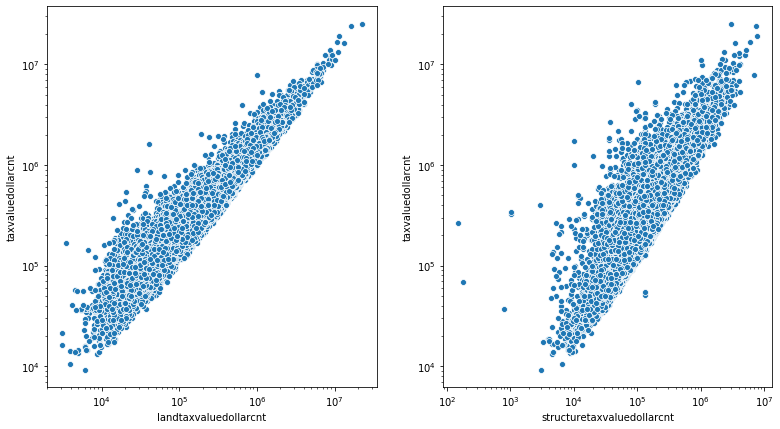

In [157]:
plt.figure(figsize=(13,7))

plt.subplot(121)
ax = sns.scatterplot(data=train, x='landtaxvaluedollarcnt', y='taxvaluedollarcnt')
ax.set(xscale='log')
ax.set(yscale='log')

plt.subplot(122)
ax = sns.scatterplot(data=train, x='structuretaxvaluedollarcnt', y='taxvaluedollarcnt')
ax.set(xscale='log')
ax.set(yscale='log')

[None]

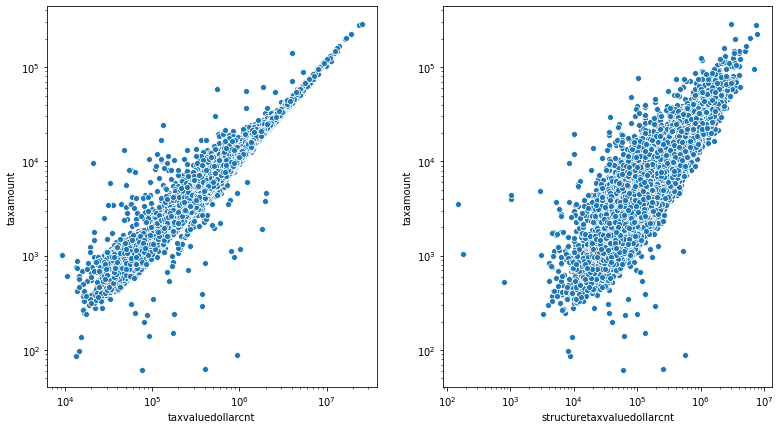

In [161]:
plt.figure(figsize=(13,7))

plt.subplot(121)
ax = sns.scatterplot(data=train, x='taxvaluedollarcnt', y='taxamount')
ax.set(xscale='log')
ax.set(yscale='log')

plt.subplot(122)
ax = sns.scatterplot(data=train, x='structuretaxvaluedollarcnt', y='taxamount')
ax.set(xscale='log')
ax.set(yscale='log')

### Columns that are dropped

In [193]:
train.propertylandusedesc.value_counts()

Single Family Residential    31026
Residential General              2
Name: propertylandusedesc, dtype: int64

In [179]:
# Drop column assessmentyear. 

train.assessmentyear.value_counts()

2016.0    31028
Name: assessmentyear, dtype: int64

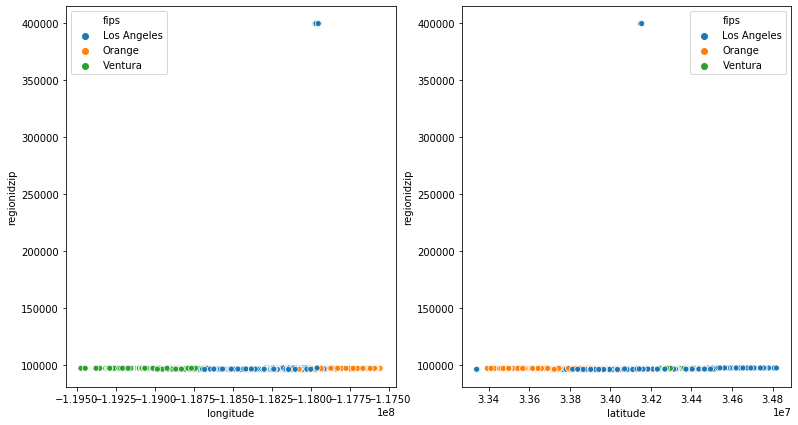

In [164]:
plt.figure(figsize=(13,7))

plt.subplot(121)
sns.scatterplot(data=train, x='longitude', y='regionidzip', hue='fips')

plt.subplot(122)
sns.scatterplot(data=train, x='latitude', y='regionidzip', hue='fips')

In [137]:
train.regionidcounty.value_counts(), train.fips.value_counts()

(3101.0    20155
 1286.0     8276
 2061.0     2597
 Name: regionidcounty, dtype: int64,
 Los Angeles    20155
 Orange          8276
 Ventura         2597
 Name: fips, dtype: int64)

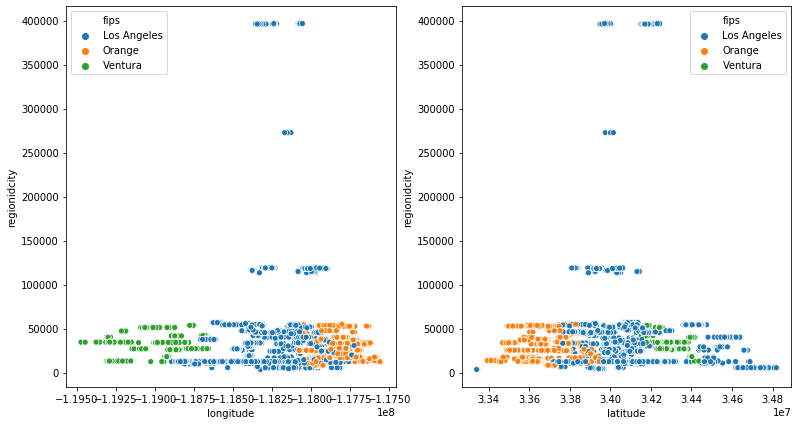

In [165]:
plt.figure(figsize=(13,7))

plt.subplot(121)
sns.scatterplot(data=train, x='longitude', y='regionidcity', hue='fips')

plt.subplot(122)
sns.scatterplot(data=train, x='latitude', y='regionidcity', hue='fips')

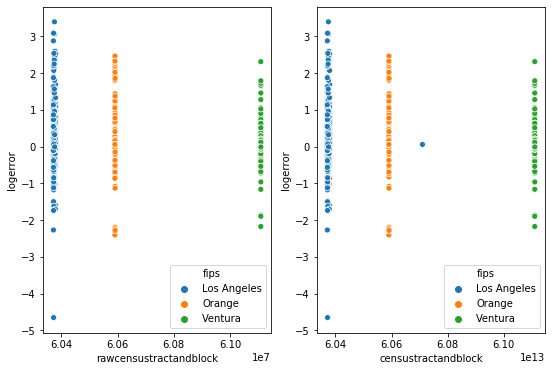

In [169]:
plt.figure(figsize=(9,6))

plt.subplot(121)
sns.scatterplot(data=train, x='rawcensustractandblock', y='logerror', hue='fips')

plt.subplot(122)
sns.scatterplot(data=train, x='censustractandblock', y='logerror', hue='fips')

### Explore the interactions between featureas and target variables

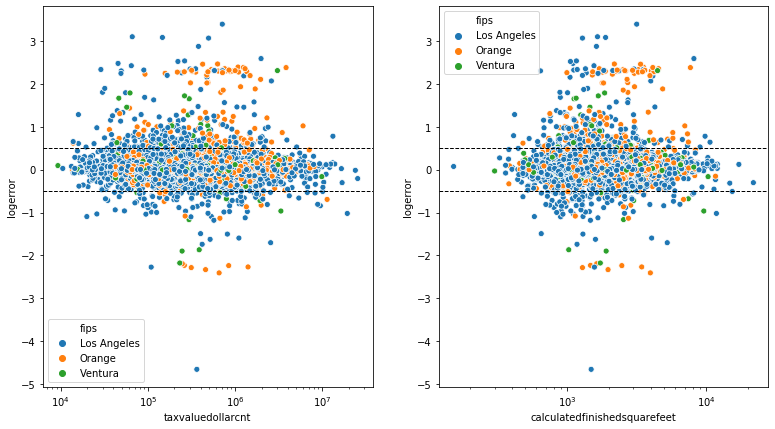

In [28]:
plt.figure(figsize=(13,7))

plt.subplot(121)
ax1 = sns.scatterplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='fips')
ax1.set(xscale='log')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)

plt.subplot(122)
ax2 = sns.scatterplot(data=train, x='calculatedfinishedsquarefeet', y='logerror', hue='fips')
ax2.set(xscale='log')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)

[Text(0.5, 362.8309090909091, '')]

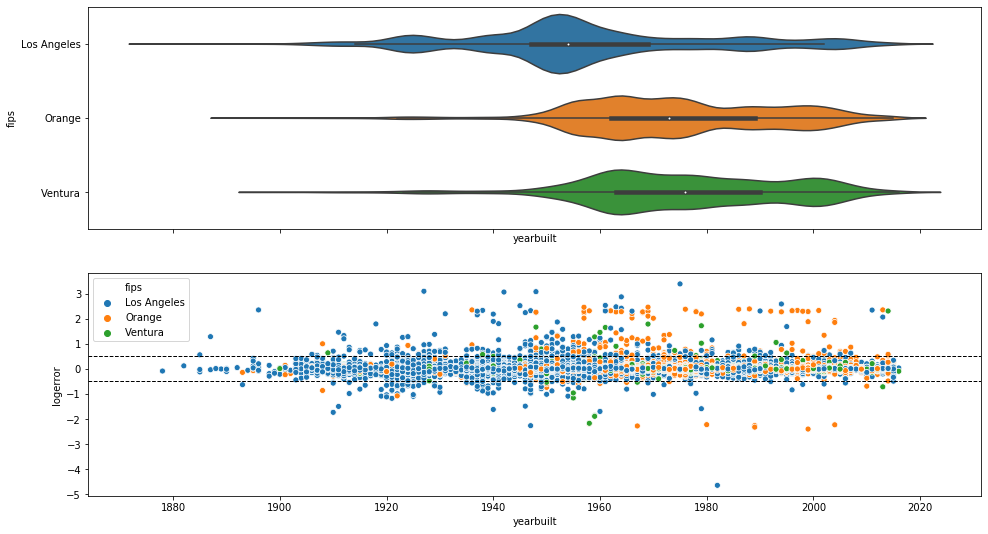

In [29]:
# Cut the window into 2 parts
fig, (ax_violin, ax_scatter) = plt.subplots(2, sharex=True, figsize=(16,9),  
                                            gridspec_kw={"height_ratios": (0.5, 0.5)})

# Add a graph in each part
sns.violinplot(data=train, x='yearbuilt', y='fips', ax=ax_violin)
sns.scatterplot(data=train, x='yearbuilt', y='logerror', hue='fips', ax=ax_scatter)
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)

# Add title
ax_box.set_title('Distribution of the control cell viability data')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

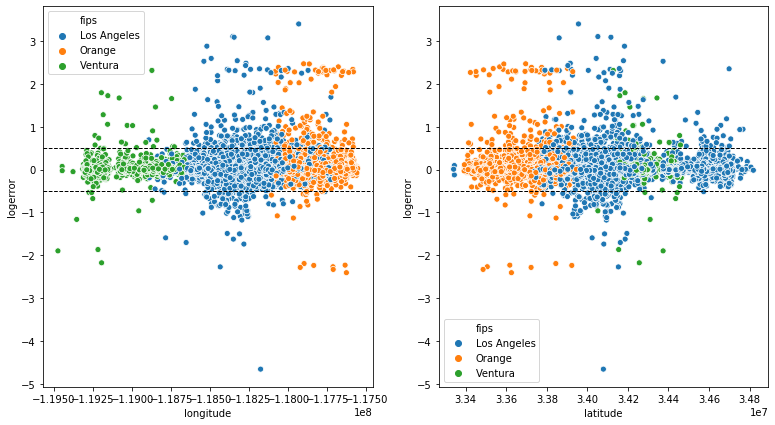

In [31]:
plt.figure(figsize=(13,7))

plt.subplot(121)
sns.scatterplot(data=train, x='longitude', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)

plt.subplot(122)
sns.scatterplot(data=train, x='latitude', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)

<Figure size 1152x648 with 0 Axes>

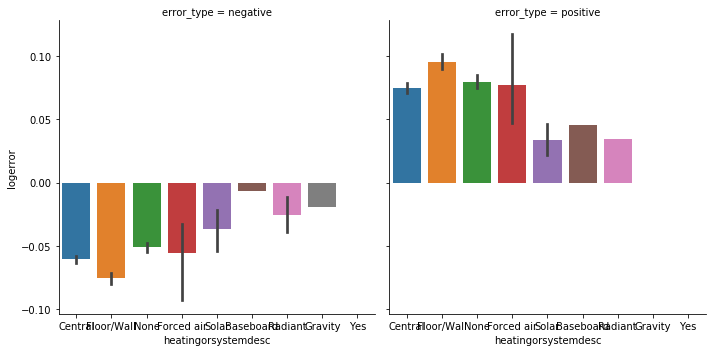

In [192]:
sns.catplot(data=train, x='heatingorsystemdesc', y='logerror', col='error_type', kind='bar')

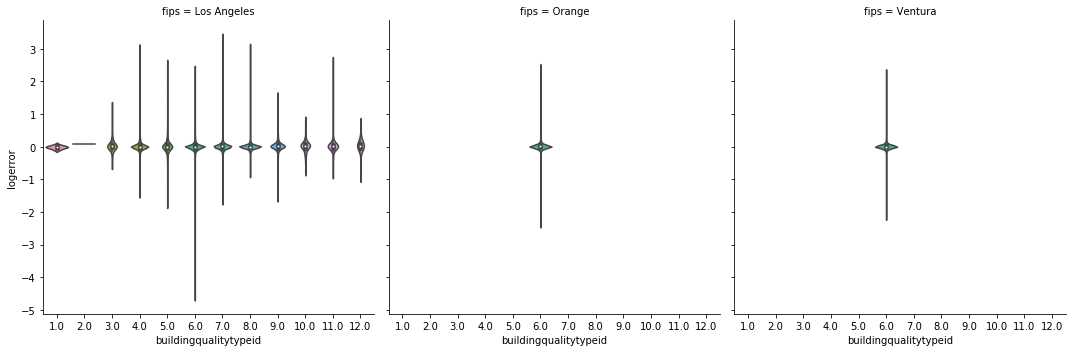

In [189]:
sns.catplot(data=train, x='buildingqualitytypeid', y='logerror', col='fips', kind='violin')

Text(0.5, 1.0, 'Barplot of the logerror based on fips and type error ')

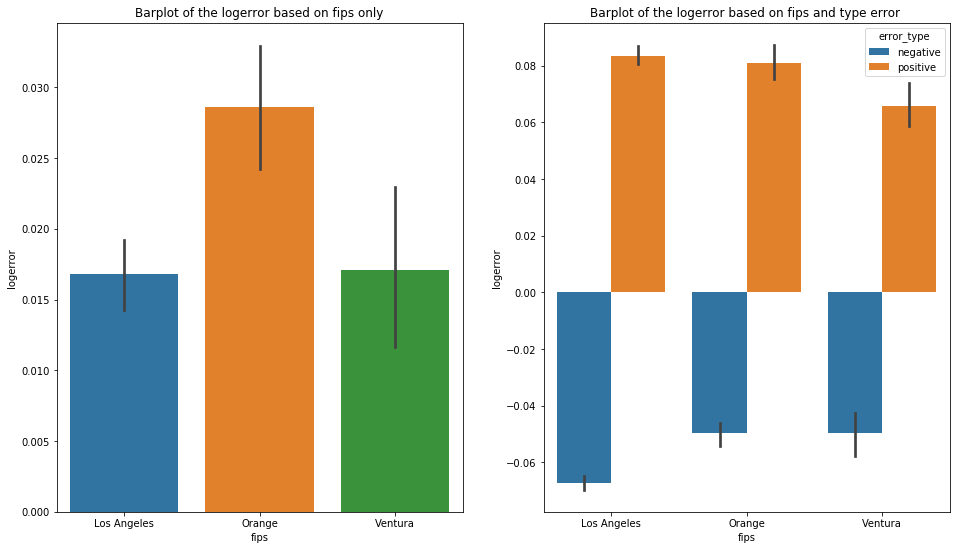

In [64]:
# Barplot the logerror among the three counties

plt.subplot(121)
sns.barplot(x='fips', y='logerror', data=train)
plt.title('Barplot of the logerror based on fips only')


plt.subplot(122)
sns.barplot(x='fips', y='logerror', hue='error_type', data=train)
plt.title('Barplot of the logerror based on fips and type error ')

### Hypothesis 1: Is the logerror sigfiniantly different among the three countries?
#### 1-a: Is the positive logerror significanlty different among the three counties?
Conclusion: The positive error in Ventura county is significantly different than the other two counties.

#### 1-b: Is the negative logerror significanlty different among the three counties?
Conclusion: The negative error in Los Angeles county is significantly different than the other two counties. 

In [65]:
train.head()

,propertylandusetypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,error_type
29866,261.0,12074309,2.0,2.0,8.0,1432.0,1432.0,Los Angeles,2.0,34179406.0,...,344570.0,2016.0,275665.0,3860.72,6.037301e+13,-0.006079,2017-08-18,Central,Single Family Residential,negative
41663,261.0,12669907,2.0,3.0,6.0,1854.0,1854.0,Los Angeles,2.0,33807692.0,...,1877197.0,2016.0,1125912.0,21149.80,6.037651e+13,-0.017067,2017-08-04,Central,Single Family Residential,negative
15079,261.0,11302417,3.0,3.0,7.0,2542.0,2542.0,Los Angeles,3.0,34678747.0,...,195053.0,2016.0,36983.0,3259.47,6.037901e+13,-0.002666,2017-07-07,Central,Single Family Residential,negative
16280,261.0,11390652,2.0,4.0,6.0,1060.0,1060.0,Los Angeles,2.0,33985638.0,...,338074.0,2016.0,270460.0,4230.63,6.037235e+13,-0.056795,2017-03-24,Floor/Wall,Single Family Residential,negative
45895,261.0,12873988,2.0,3.0,6.0,1274.0,1274.0,Los Angeles,2.0,34071220.0,...,197982.0,2016.0,109929.0,2534.61,6.037403e+13,0.012496,2017-04-25,Central,Single Family Residential,positive


In [90]:
# Create masks to represnt each subgroup

mask_LA_positive = (train.fips == 'Los Angeles') & (train.logerror > 0)
mask_LA_negative = (train.fips == 'Los Angeles') & (train.logerror < 0)
mask_orange_positive = (train.fips == 'Orange') & (train.logerror > 0)
mask_orange_negative = (train.fips == 'Orange') & (train.logerror < 0)
mask_ventura_positive = (train.fips == 'Ventura') & (train.logerror > 0)
mask_ventura_negative = (train.fips == 'Ventura') & (train.logerror < 0)

In [95]:
# Create dfs for LA with positive and negative error

train_LA_positive = train[mask_LA_positive]
train_LA_negative = train[mask_LA_negative]

train_LA_positive.shape, train_LA_negative.shape

((11229, 30), (8926, 30))

In [92]:
# Create dfs for Orange with positive and negative error

train_orange_positive = train[mask_orange_positive]
train_orange_negative = train[mask_orange_negative]

train_orange_positive.shape, train_orange_negative.shape

((4953, 30), (3323, 30))

In [93]:
# Create dfs for Ventura with positive and negative error

train_ventura_positive = train[mask_ventura_positive]
train_ventura_negative = train[mask_ventura_negative]

train_ventura_positive.shape, train_ventura_negative.shape

((1502, 30), (1095, 30))

In [84]:
# Test hypothesis 1-a: LA vs. Orange

s, p = stats.levene(train_LA_positive.logerror, train_orange_positive.logerror)
if p < 0.05:
    s1, p1 = stats.ttest_ind(train_LA_positive.logerror, train_orange_positive.logerror, equal_var=False)
else:
    s1, p1 = stats.ttest_ind(train_LA_positive.logerror, train_orange_positive.logerror, equal_var=True)
    
(s, p), (s1, p1)

((0.0013425970483023466, 0.970771332466424),
 (0.7484674984070805, 0.4541891015842584))

In [85]:
# Test hypothesis 1-a: LA vs. Ventura

s, p = stats.levene(train_LA_positive.logerror, train_ventura_positive.logerror)
if p < 0.05:
    s1, p1 = stats.ttest_ind(train_LA_positive.logerror, train_ventura_positive.logerror, equal_var=False)
else:
    s1, p1 = stats.ttest_ind(train_LA_positive.logerror, train_ventura_positive.logerror, equal_var=True)
    
(s, p), (s1, p1)

((9.683467501601045, 0.001863448773136243),
 (4.22537070820559, 2.487449434418571e-05))

In [87]:
# Test hypothesis 1-a: Orange vs. Ventura

s, p = stats.levene(train_orange_positive.logerror, train_ventura_positive.logerror)
if p < 0.05:
    s1, p1 = stats.ttest_ind(train_orange_positive.logerror, train_ventura_positive.logerror, equal_var=False)
else:
    s1, p1 = stats.ttest_ind(train_orange_positive.logerror, train_ventura_positive.logerror, equal_var=True)
    
(s, p), (s1, p1)

((5.745202997544379, 0.01656201554886734),
 (3.064704317895413, 0.0021945565528481946))

In [88]:
# Test hypothesis 1-b: LA vs. Orange

s, p = stats.levene(train_LA_negative.logerror, train_orange_negative.logerror)
if p < 0.05:
    s1, p1 = stats.ttest_ind(train_LA_negative.logerror, train_orange_negative.logerror, equal_var=False)
else:
    s1, p1 = stats.ttest_ind(train_LA_negative.logerror, train_orange_negative.logerror, equal_var=True)
    
(s, p), (s1, p1)

((31.763203341141647, 1.7800644718073836e-08),
 (-6.956355234650273, 3.880509685642323e-12))

In [89]:
# Test hypothesis 1-c: LA vs. Ventura

s, p = stats.levene(train_LA_negative.logerror, train_ventura_negative.logerror)
if p < 0.05:
    s1, p1 = stats.ttest_ind(train_LA_negative.logerror, train_ventura_negative.logerror, equal_var=False)
else:
    s1, p1 = stats.ttest_ind(train_LA_negative.logerror, train_ventura_negative.logerror, equal_var=True)
    
(s, p), (s1, p1)

((12.403315564468352, 0.00043047903664873374),
 (-4.319683550626524, 1.6773027646581693e-05))

In [90]:
# Test hypothesis 1-c: Orange vs. Ventura

s, p = stats.levene(train_orange_negative.logerror, train_ventura_negative.logerror)
if p < 0.05:
    s1, p1 = stats.ttest_ind(train_orange_negative.logerror, train_ventura_negative.logerror, equal_var=False)
else:
    s1, p1 = stats.ttest_ind(train_orange_negative.logerror, train_ventura_negative.logerror, equal_var=True)
    
(s, p), (s1, p1)

((0.006202272892595083, 0.9372314553585865),
 (0.005234191908555182, 0.995823974582728))

In [96]:
train_LA_positive.logerror.describe()

count    11229.000000
mean         0.083543
std          0.176352
min          0.000003
25%          0.016059
50%          0.036347
75%          0.080583
max          3.394544
Name: logerror, dtype: float64

[Text(0.5, 0, '')]

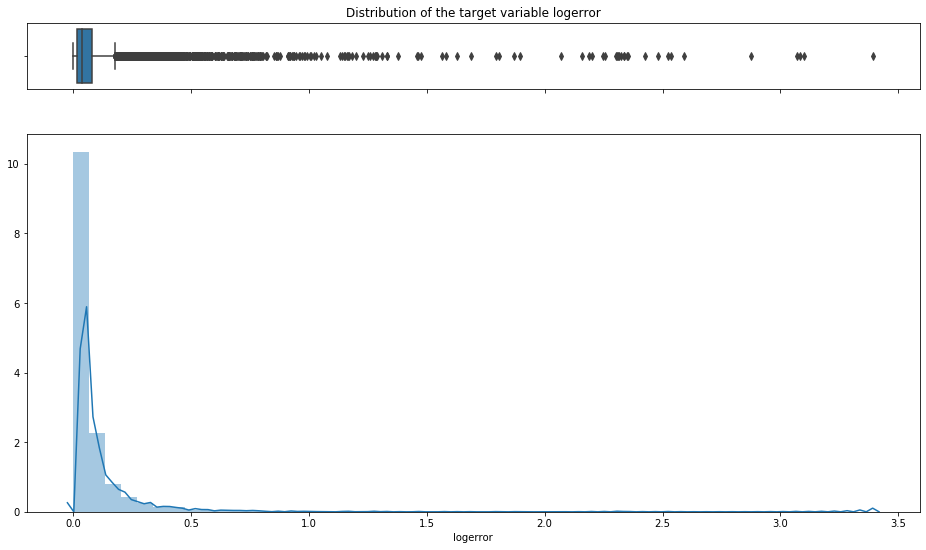

In [95]:
# Visualize the target varible by boxplot and histogram

# Cut the window into 2 parts
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(16,9),  
                                      gridspec_kw={"height_ratios": (0.15, 0.85)})

# Add a graph in each part
sns.boxplot(train_LA_positive.logerror, ax=ax_box)
sns.distplot(train_LA_positive.logerror, kde=True, ax=ax_hist)


# Add title
ax_box.set_title('Distribution of the target variable logerror')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')